# Diagnóstico y Corrección de las Hipótesis del Modelo Lineal Múltiple

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_ljungbox


data = pd.read_cvs("/content/drive/MyDrive/Econometria/forestfires2.csv")

data.info()

AttributeError: module 'pandas' has no attribute 'read_cvs'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_ljungbox


data = pd.read_csv('/content/drive/MyDrive/Econometria/forestfires2.csv')
#X – Coordenada espacial X del área forestal (grid).
#Y – Coordenada espacial Y del área forestal (grid).
#month – Mes del año en que ocurrió el incendio (jan–dec).
#day – Día de la semana en que ocurrió el incendio (mon–sun).
#FFMC – Fine Fuel Moisture Code. Índice de humedad del combustible fino; valores altos indican combustibles más secos.
#DMC – Duff Moisture Code. Índice de humedad del material orgánico superficial del suelo.
#DC – Drought Code. Índice de sequía profunda del suelo; valores altos indican condiciones de sequía prolongada.
#ISI – Initial Spread Index. Índice de velocidad potencial de propagación inicial del fuego.
#temp – Temperatura del aire en grados Celsius (°C).
#RH – Humedad relativa del aire (%).
#wind – Velocidad del viento (km/h).
#rain – Precipitación acumulada (mm/m²).
#area – Área quemada por el incendio forestal (hectáreas).
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


In [13]:
y = data['area']
X = data[['temp', 'RH', 'wind', 'rain', 'FFMC', 'DMC', 'DC', 'ISI']]

X = sm.add_constant(X)

modelo = sm.OLS(y, X).fit()
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:                   area   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.033
Date:                Mon, 15 Dec 2025   Prob (F-statistic):              0.410
Time:                        08:14:44   Log-Likelihood:                -2876.3
No. Observations:                 517   AIC:                             5771.
Df Residuals:                     508   BIC:                             5809.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4938     62.048      0.040      0.9

## Normalidad

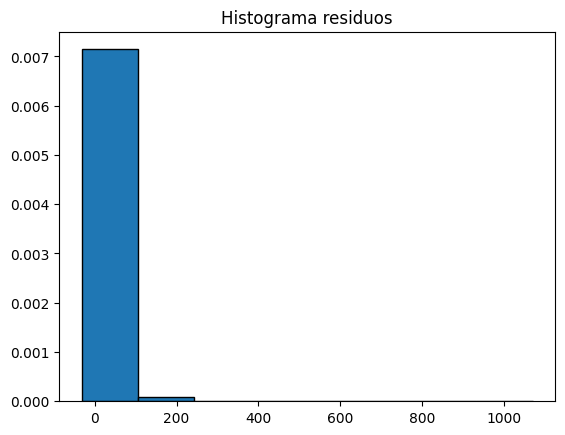

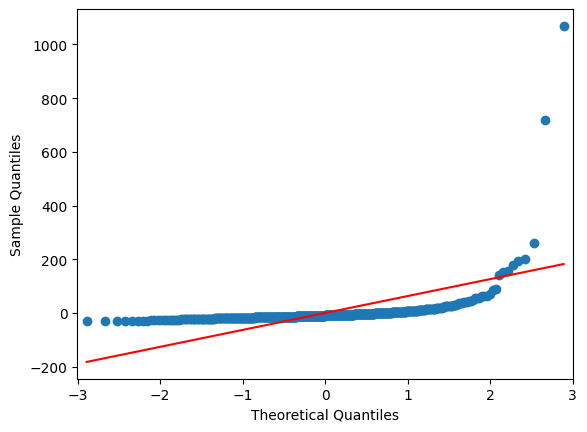

KstestResult(statistic=np.float64(0.3188129002816524), pvalue=np.float64(3.1059793119128364e-47), statistic_location=np.float64(-0.4227988207179961), statistic_sign=np.int8(-1))

In [14]:
resid = modelo.resid
resid_std = (resid - resid.mean())/resid.std(ddof=1)

plt.hist(resid, bins=8, edgecolor='black', density=True)
plt.title('Histograma residuos')
plt.show()

sm.qqplot(resid, line='s')
plt.show()

stats.kstest(resid_std, 'norm')

## Multicolinealidad

In [15]:
vif = pd.DataFrame()
vif['var']=X.columns
vif['VIF']=[variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
vif

,var,VIF
0,const,491.469139
1,temp,2.661897
2,RH,1.899989
3,wind,1.140610
4,rain,1.044801
5,FFMC,1.695255
6,DMC,2.330688
7,DC,2.078205
8,ISI,1.578258


In [ ]:
cond=np.linalg.cond(X.values.T@X.values)
np.sqrt(cond)

np.float64(27470.939248297887)

## Heteroscedasticidad

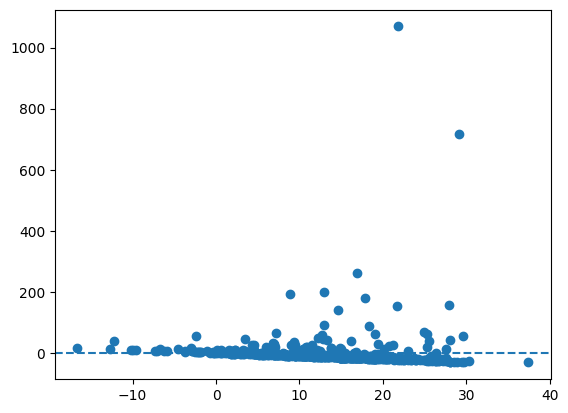

In [16]:
fitted = modelo.fittedvalues
plt.scatter(fitted, resid); plt.axhline(0,ls='--'); plt.show()

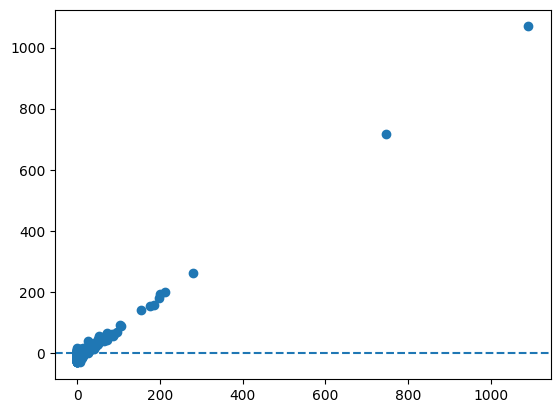

In [18]:
plt.scatter(data['area'], resid); plt.axhline(0,ls='--'); plt.show()

In [19]:
sms.het_goldfeldquandt(y,X)

(np.float64(0.5200927334529175), np.float64(0.9999998406159613), 'increasing')

In [20]:
sms.het_breuschpagan(resid,X)

(np.float64(4.167245315851523),
 np.float64(0.8417274227373381),
 np.float64(0.5159968335477165),
 np.float64(0.8446942864397488))

In [21]:
sms.het_white(resid,X)

(np.float64(11.123557696958628),
 np.float64(0.9999995530762219),
 np.float64(0.2481580154968574),
 np.float64(0.9999997435069237))

In [25]:
glejser_y = np.abs(resid)
eps = 1e-6  #Evitar la division sin alterar resultados para variables que no son bug (rain)
#Glejser no es ideal para variables meteorológicas

for v in ['temp', 'RH', 'wind', 'rain', 'FFMC', 'DMC', 'DC', 'ISI']:
    print(f"Variable {v}:")
    for h in [-3, -2, -1, 1, 2, 3]:
        z = (X[v].astype(float) +eps)**h
        Z = pd.DataFrame({'zvar': z})

        glejser = sm.OLS(glejser_y, sm.add_constant(Z)).fit()

        pval = glejser.pvalues['zvar']
        print(f"\t p-valor {v}^{h}: {pval}. R^2: {glejser.rsquared}")

Variable temp:
	 p-valor temp^-3: 0.5991951825142787. R^2: 0.0005367097865096593
	 p-valor temp^-2: 0.26403131154336157. R^2: 0.002421737164415405
	 p-valor temp^-1: 0.0420642304501689. R^2: 0.008000117459184164
	 p-valor temp^1: 0.0007469574310704712. R^2: 0.021854037701317997
	 p-valor temp^2: 0.00047170703424977264. R^2: 0.023479509294267453
	 p-valor temp^3: 0.0006957051094916924. R^2: 0.022105101113288783
Variable RH:
	 p-valor RH^-3: 0.11640592446800307. R^2: 0.0047796427849360335
	 p-valor RH^-2: 0.03959255763885824. R^2: 0.008198000203143652
	 p-valor RH^-1: 0.01674448372130151. R^2: 0.011061691313441924
	 p-valor RH^1: 0.01673461481534919. R^2: 0.011063681109498957
	 p-valor RH^2: 0.03128682576450931. R^2: 0.00897242966434919
	 p-valor RH^3: 0.06167319667621073. R^2: 0.006763813514533146
Variable wind:
	 p-valor wind^-3: 0.627649309959245. R^2: 0.0004571585453134741
	 p-valor wind^-2: 0.4308332489943216. R^2: 0.0012054455406740328
	 p-valor wind^-1: 0.3374650424385989. R^2: 0.

### Mínimos Cuadrados Ponderados

In [30]:
weights = 1/(data['area'] + 1)
#area tiene muchos ceros entonces genera pesos infinitos, lo cual invalida WLS
# +1 evita la division con cero y hace consistente la transformacion logaritmica
wls_results = sm.WLS(y,X,weights=weights).fit()
wls_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                   area   R-squared:                       0.001
Model:                            WLS   Adj. R-squared:                 -0.014
Method:                 Least Squares   F-statistic:                   0.09471
Date:                Mon, 15 Dec 2025   Prob (F-statistic):              0.999
Time:                        08:26:42   Log-Likelihood:                -1665.9
No. Observations:                 517   AIC:                             3350.
Df Residuals:                     508   BIC:                             3388.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2503      3.895      0.064      0.949      -7.401       7.902
temp          -0.0055      0.063     -0.088      0.930      -0.128       0.117
RH            -0.0043      0.018     -0.242      0.809      -0.039       0.030
wind           0.0636      0.123      0.515      0.607      -0.179       0.306
rain           0.5491      1.424      0.386      0.700      -2.249       3.347
FFMC           0.0037      0.040      0.093      0.926      -0.074       0.081
DMC            0.0003      0.005      0.071      0.943      -0.009       0.010
DC             0.0004      0.001      0.377      0.706      -0.002       0.003
ISI           -0.0127      0.050     -0.256      0.798      -0.111       0.085
==============================================================================
Omnibus:                      480.907   Durbin-Watson:                   1.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16805.851
Skew:                           4.029   Prob(JB):                         0.00
Kurtosis:                      29.744   Cond. No.                     1.18e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.18e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Autocorrelación

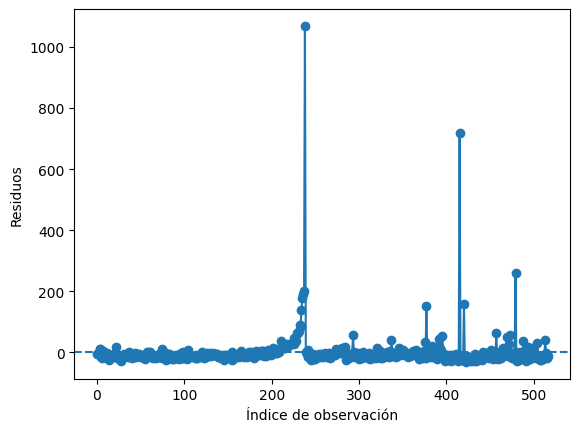

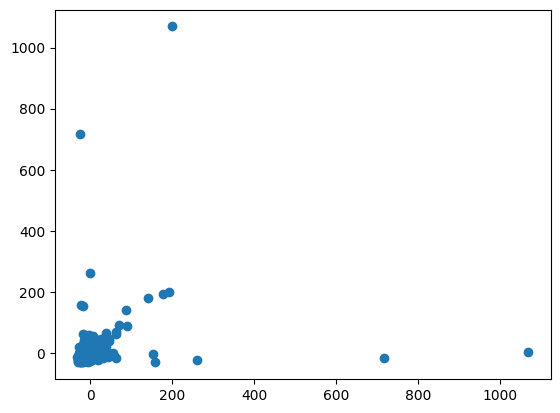

np.float64(1.6446942454522935)

In [32]:
plt.plot( modelo.resid, marker='o');
plt.axhline(0,ls='--');
plt.xlabel('Índice de observación')
plt.ylabel('Residuos')
plt.show()

plt.scatter(modelo.resid[:-1], modelo.resid[1:]); plt.show()

durbin_watson(modelo.resid)

In [ ]:
acorr_ljungbox(modelo.resid,lags=[1,2,3,4,5],return_df=True)

,lb_stat,lb_pvalue
1,181.306840,2.512406e-41
2,345.524522,9.339066e-76
3,492.982350,1.582985e-106
4,628.105247,1.279563e-134
5,753.145303,1.579215e-160


## Prais-Winsten

In [33]:
dw = durbin_watson(modelo.resid)
rho = 1 - (dw/2)

mco_autocorr=sm.GLSAR(y, sm.add_constant(X), rho=rho)
res=mco_autocorr.iterative_fit(maxiter=100,rtol=10**(-10))


print ('Iteraciones = %d Converge: %s' % (res.iter, res.converged) )
print ('Rho =  ', mco_autocorr.rho)
print(res.summary())

Iteraciones = 9 Converge: True
Rho =   [0.18275393]
                           GLSAR Regression Results                           
Dep. Variable:                   area   R-squared:                       0.018
Model:                          GLSAR   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.141
Date:                Mon, 15 Dec 2025   Prob (F-statistic):              0.334
Time:                        08:28:54   Log-Likelihood:                -2862.7
No. Observations:                 516   AIC:                             5743.
Df Residuals:                     507   BIC:                             5782.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
